In [1]:
%%capture
## compile PyRoss for this notebook
import os
owd = os.getcwd()
os.chdir('../../')
%run setup.py install
os.chdir(owd)
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pyross

In this notebook we consider a control protocol consisting of an initial lockdown, which is then partly released. For our numerical study we generate synthetic data using the stochastic SEAI5R model.

While we use the Denmark age structure and contact matrix, we emphasise that **the model parameters considered in this notebook have NOT been obtained from real data, but rather are chosen ad-hoc**.

**Outline of this notebook:**

1. We briefly summarize the SEAI5R model.
2. We load the age structure and contact matrix for Denmark. The contact matrix is generally given as
\begin{equation}
    C = C_H + C_W + C_S + C_O,
\end{equation}
where the four terms denote the number of contacts at home, work, school, and all other remaining contacts.
3. We define the other model parameters of the SEAI5R model **(again, these are not fitted to any real data, but rather chosen ad-hoc)**.
4. We define a "lockdown-protocol":
    1. After a fixed time, a lockdown is imposed. The contact matrix is reduced to 
    \begin{equation}
        C = C_H + 0.1\cdot C_W + 0.4 \cdot C_O,
        \end{equation}
        i.e. the "home" contacts $C_H$, and 10% of the "work" as well as 40% of the "other" contacts are reainted. The latter two model that even in lockdown, people go to work, and that initially people might be lenient in following the lockdown advice.
    2. 5 Days after the initial lockdown, the 40% "social interaction" part of the contact matrix is removed, and the contact matrix becomes
        \begin{equation}
        C = C_H + 0.1\cdot C_W.
        \end{equation}
        This models that people take the lockdown seriously and seize to interact socially.
    3. 50 Days after the initial lockdown, 50% of the "school" contacts are added to the contact matrix,
        \begin{equation}
        C = C_H + 0.1\cdot C_W + 0.5 \cdot C_S.
        \end{equation}
        This models an opening of schools, with a social distancing protocol in place such that the number of contacts at school is halved.
5. We run 150 stochastic simulations of this lockdown protocol, and find that in Stage 2 (only home and 10% of work contacts), the total number of known active infectives (the sum of the stages symptomatic infective, hospitalised, and in ICU) shows a maximum and then decreases. After schools are opened, the total number of known active infectives shows a minimum and starts to decrease again. We plot the distribution of waiting time between change in the contact matrix and the extrema in the stochastic time series.
6. Finally, we consider the protocol from point 4 again, but this time with a prefactor 0.2 in front of $C_S$, signifying a more strict social distancing protocol. Running 150 stochastic simulations with this protocol, we find that this time the total number of active infectives keeps decreases even after schools have been opened.
        


## 1. Brief summary of the model 

The SEAI5R model contains the following stages:


![caption](SEAI5R.jpg)

If a susceptible individual is infected, it enters the "exposed" class, where it does not show symptoms and is not yet infective. In the subsequent class, called "activated", the individual still does not show symptoms, but is infective. After the "activated" class, an individual is either a symptomatic or an asymptomatic infective. Those who are asymptomatic recover, those who show symptoms either recover, or need to be hospitalised. The condition of a hospitalised individual might improve, so that the individual recovers, or worsens, at which point the individual enters the "ICU" class. From this class the individual can again recover, or enter a final "mortality" class.





## 2. Load Denmark age structure and contact matrix

In [3]:
my_data = np.genfromtxt('../data/age_structures/Denmark-2019.csv', delimiter=',', skip_header=1)
aM, aF = my_data[:, 1], my_data[:, 2]

Ni0=aM+aF;

M=16  ## number of age classes

Ni = Ni0[:M]
N=np.sum(Ni)

print("Age groups are in brackets of 5 (i.e. 0-4, 5-9, 10-14, .. , 75-79).")
print("Number of individuals in each bracket:")
print(Ni.astype('int'))
print("Total number of individuals: {0}".format(np.sum(Ni.astype('int'))))

Age groups are in brackets of 5 (i.e. 0-4, 5-9, 10-14, .. , 75-79).
Number of individuals in each bracket:
[302353 305513 338779 341219 379522 395469 342443 320132 366147 385944
 422585 381360 338039 319145 346572 220374]
Total number of individuals: 5505596


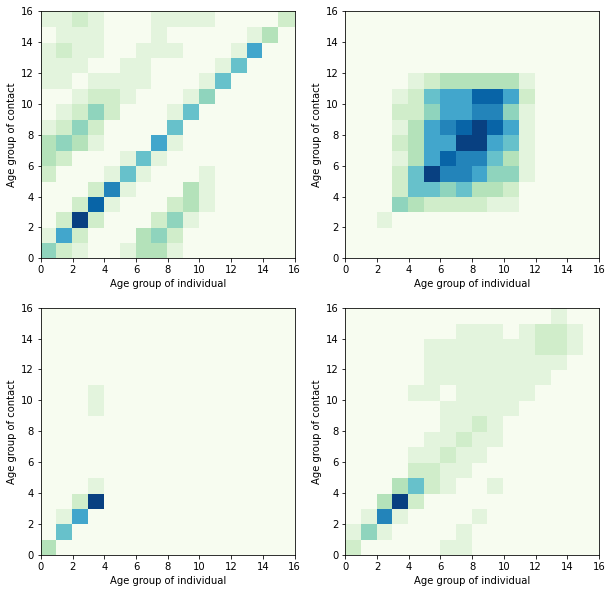

In [22]:
# Get individual contact matrices
CH, CW, CS, CO = pyross.contactMatrix.Denmark()

# By default, home, work, school, and others contribute to the contact matrix
C = CH + CW + CS + CO

# Illustrate the individual contact matrices:
fig,aCF =  plt.subplots(2,2,figsize=(10,10));
aCF[0][0].pcolor(CH, cmap=plt.cm.get_cmap('GnBu', 10));
aCF[0][1].pcolor(CW, cmap=plt.cm.get_cmap('GnBu', 10));
aCF[1][0].pcolor(CS, cmap=plt.cm.get_cmap('GnBu', 10));
aCF[1][1].pcolor(CO, cmap=plt.cm.get_cmap('GnBu', 10));
for i in range(2):
    for j in range(2):
        aCF[i][j].set_xlabel('Age group of individual')
        aCF[i][j].set_ylabel('Age group of contact')

The above contact matrices illustrate the interactions at home (upper left), work (upper right), school (lower left), and the other remaining contacts (lower right). x- and y- axes denote the age groups, a darker color indicates more interaction.

## 3. Define model parameters

**Note: These have not been fitted to real data.**

In [5]:
beta  = 0.036692            # infection rate 

gE    = 1/5.
gA    = 1/4.
gIa   = 1./3.                # recovery rate of asymptomatic infectives 
gIs   = 1./7                # recovery rate of symptomatic infectives 
alpha = 0.4                 # fraction of asymptomatic infectives 
fsa   = 0.2                 # the self-isolation parameter   
fh    = 0
gIh   = 1/7
gIc   = 1/14
 
sa    = 0*np.ones(M)      #  rate of additional/removal of population by birth etc
sa[0]     = 0            # birth
sa[3] = 0          # mortality


hh   = 0.1*np.ones(M)       # fraction which goes from Is to hospital
hh[:M] = 0.01
hh[M:2*M] = 0.025
cc   = 0.05*np.ones(M)      # fraction which goes from  hospital to ICU 
mm   = 0.4*np.ones(M)       # mortality from IC


# initial conditions    
Is_0 = np.zeros((M)); 
 
Ia_0 = 10*np.ones((M)) # start with 10 asymptomatic infectives
R_0  = np.zeros((M))
E_0  = np.zeros((M))
A_0  = np.zeros((M))
Ih_0  = np.zeros((M))
Ic_0  = np.zeros((M))
Im_0  = np.zeros((M))

S_0  = Ni - (E_0 + A_0 + Ia_0 + Is_0 + Ih_0 + Ic_0 +Im_0 + R_0)

## 4. Define events for protocol

In [6]:
# Dummy event for initial (standard) contact matrix
events = [lambda t: 1]
contactMatrices = [C]

# After 20 days, start lockdown
lockdown_threshold_0 = 20
def event0(t,rp):
    return t - lockdown_threshold_0
events.append(event0)
contactMatrices.append( CH + 0.1*CW + 0.4*CO )


# After 25 days, decrease contacts even further
lockdown_threshold_1 = 25
def event1(t,rp):
    return t- lockdown_threshold_1
events.append(event1)
contactMatrices.append( CH + 0.1*CW)


# After 70 days, add 50% of school contacts to contact matrix
lockdown_threshold_2 = 70
def event2(t,rp):
    return t - lockdown_threshold_2
events.append(event2)
contactMatrices.append( CH + 0.1*CW + 0.5*CS ) # school opens, with social distancing

## 5. Simulate protocol and analyse results

#### Initialise pyross.control, run and plot a single test simulation

In [7]:
# duration of simulation
Tf=150;  Nf=Tf+1;  

# intantiate model
parameters = {'alpha':alpha,'beta':beta, 'gIa':gIa,'gIs':gIs,
              'gIh':gIh,'gIc':gIc,  'gE':gE, 'gA':gA,
              'fsa':fsa, 'fh':fh, 
              'sa':sa, 
              'hh':hh, 'cc':cc, 'mm':mm}
model = pyross.control.SEAI5R(parameters, M, Ni.copy())

# run model once
method='gillespie'
data=model.simulate(S_0, E_0, A_0, Ia_0, Is_0, Ih_0, Ic_0, Im_0,
                    events,contactMatrices, Tf, Nf,
                                method=method)

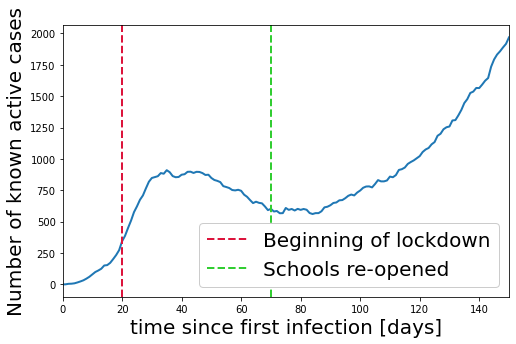

In [8]:
# Plot result

t = data['t']; 

# get total population in classes
# - symptomatic infective,
# - hospitalised,
# - in ICU
y_plot = np.sum ( data['X'][:,4*M:7*M], axis = -1)

lw=2
fig,ax = plt.subplots(1,1,figsize=(8,5))
ax.plot(t,y_plot,lw=lw,)
ax.axvline(data['events_occured'][0][0],
           color='crimson',lw=lw,
          label='Beginning of lockdown',ls='--')
ax.axvline(data['events_occured'][-1][0],
 color='limegreen',lw=lw,
          label='Schools re-opened',ls='--')
ax.set_xlim(0,Tf)
fs=20
ax.legend(loc='best',fontsize=fs,framealpha=1)
ax.set_xlabel('time since first infection [days]',fontsize=fs)
ax.set_ylabel('Number of known active cases',fontsize=fs)
plt.show()
plt.close(fig)

#### Run 150 simulations with protocol, then

* plot trajectories,
* plot mean trajectory + standard deviation,
* plot distribution of delay between interventions (lockdown, re-opening of schools) until subsequent maximum/minimum.

In [9]:
# Run 150 simulations with this protocol
N_simulations = 150

data_results = np.zeros([N_simulations,Nf,M*9],
                        dtype=int)
for i in range(N_simulations):
    print('Running simulation {0} of {1}'.format(i+1,N_simulations),end='\r')
    data=model.simulate(S_0, E_0, A_0, Ia_0, Is_0, Ih_0, Ic_0, Im_0,
                    events,contactMatrices, Tf, Nf,
                                method=method)
    data_results[i] = data['X']

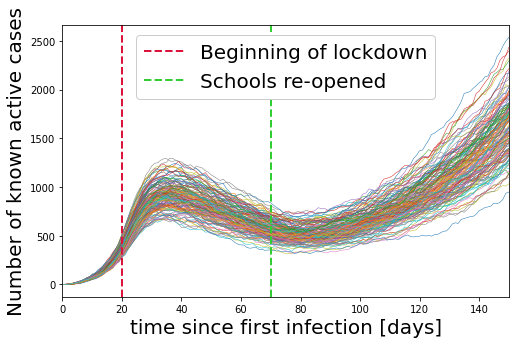

In [10]:
# Plot result

t = data['t']; 
fig,ax = plt.subplots(1,1,figsize=(8,5))
for i,e in enumerate(data_results):
    # get total population in classes
    # - symptomatic infective,
    # - hospitalised,
    # - in ICU
    y_plot = np.sum ( e[:,4*M:7*M], axis = -1)
    ax.plot(t,y_plot,lw=0.5,)
ax.axvline(data['events_occured'][0][0],
               color='crimson',lw=lw,
              label='Beginning of lockdown',ls='--')
ax.axvline(data['events_occured'][-1][0],
 color='limegreen',lw=lw,
          label='Schools re-opened',ls='--')
ax.set_xlim(0,Tf)
fs=20
ax.legend(loc='best',fontsize=fs,framealpha=1)
ax.set_xlabel('time since first infection [days]',fontsize=fs)
ax.set_ylabel('Number of known active cases',fontsize=fs)
plt.show()
plt.close(fig)

#### Mean and standard deviation

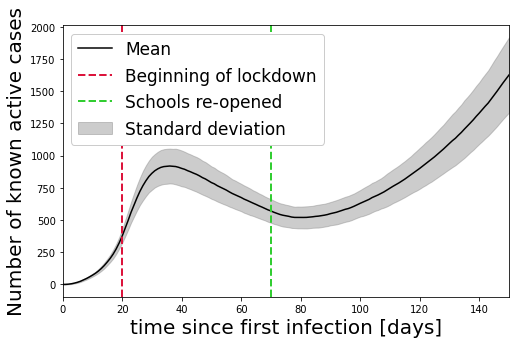

In [11]:
# For all simulations, plot total population in classes
# - symptomatic infective,
# - hospitalised,
# - in ICU

# mean and standard deviation of trajectories at every time
y_mean = np.mean( ( np.sum(data_results[:,:,4*M:7*M], axis = -1) ), axis=0)
y_std = np.std ( np.sum( data_results[:,:,4*M:7*M], axis = -1), axis =0)

t = data['t']; 
fig,ax = plt.subplots(1,1,figsize=(8,5))    
ax.fill_between(t,y_mean - y_std,y_mean+y_std,
                label='Standard deviation',
           color='grey',alpha=0.4)
ax.plot(t,y_mean,
        label='Mean',
           color='black',alpha=1)  
ax.axvline(data['events_occured'][0][0],
               color='crimson',lw=lw,
              label='Beginning of lockdown',ls='--')
ax.axvline(data['events_occured'][-1][0],
 color='limegreen',lw=lw,
          label='Schools re-opened',ls='--')
ax.set_xlim(0,Tf)
fs=20
ax.legend(loc='upper left',fontsize=17,framealpha=1)
ax.set_xlabel('time since first infection [days]',fontsize=fs)
ax.set_ylabel('Number of known active cases',fontsize=fs)
plt.show()
plt.close(fig)

#### Plot distributions for both 

* time from beginning of lockdown to subsequent peak, and
* time from opening of schools to subsequent minimum.

Mean time from beginning of lockdown to subsequent peak = 16.1 days


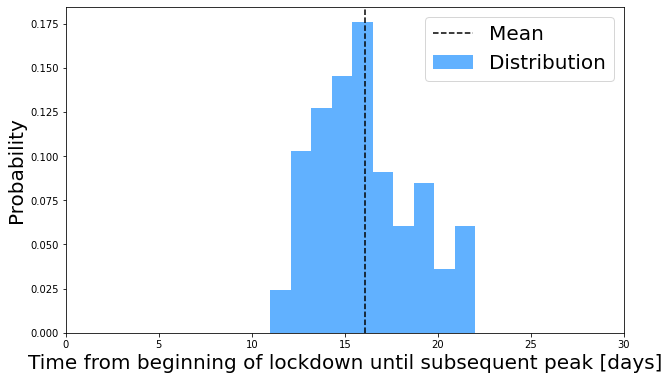

Mean time from opening of schools to subsequent minimum = 10.7 days


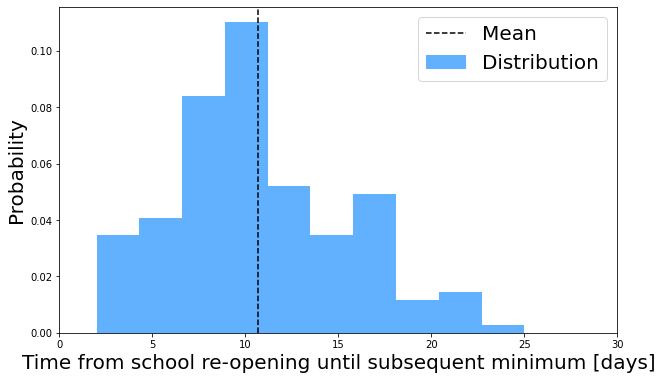

In [12]:
# calculate time from lockdown to local maximum for each trajectory
mask = (t > lockdown_threshold_0)*(t < lockdown_threshold_2)
t_mask = t[(mask)]
durations_from_lockdown_to_local_maximum = np.zeros(N_simulations,
                                                   dtype=float)
for i,e in enumerate(data_results):
    y_plot = np.sum ( e[:,4*M:7*M], axis = -1)
    index = np.argmax( y_plot[(mask)])
    durations_from_lockdown_to_local_maximum[i] = t_mask[index] - lockdown_threshold_0
print('Mean time from beginning of lockdown to subsequent peak = {0:3.1f} days'.format(np.mean(durations_from_lockdown_to_local_maximum)))


hist, bin_edges = np.histogram(durations_from_lockdown_to_local_maximum,10 ,density=True)
bin_centers = (bin_edges[1:] + bin_edges[:-1])/2.
bin_widths = bin_edges[1]-bin_edges[0]
fig, ax =plt.subplots(1,1,figsize=(10,6))
ax.axvline(np.mean(durations_from_lockdown_to_local_maximum),ls='--',color='black',
          label='Mean')
ax.bar(bin_centers,hist,bin_widths,color='dodgerblue',
       label='Distribution',alpha=0.7)
ax.set_xlabel('Time from beginning of lockdown until subsequent peak [days]',fontsize=fs)
ax.set_ylabel('Probability',fontsize=fs)
ax.legend(loc='best',fontsize=fs)
ax.set_xlim(0,30)
plt.show()
plt.close(fig)





# calculate time from opening of schools to local minimum for each trajectory
# (recall lockdown_threshold_2 = time at which schools are opened)
mask = (t > lockdown_threshold_2)*(t < Tf)
t_mask = t[(mask)]
durations_from_school_opening_to_local_minimum = np.zeros(N_simulations,
                                                   dtype=float)
for i,e in enumerate(data_results):
    y_plot = np.sum ( e[:,4*M:7*M], axis = -1)
    index = np.argmin( y_plot[(mask)])
    durations_from_school_opening_to_local_minimum[i] = t_mask[index] - lockdown_threshold_2
print('Mean time from opening of schools to subsequent minimum = {0:3.1f} days'.format(np.mean(durations_from_school_opening_to_local_minimum)))


hist, bin_edges = np.histogram(durations_from_school_opening_to_local_minimum,10 ,density=True)
bin_centers = (bin_edges[1:] + bin_edges[:-1])/2.
bin_widths = bin_edges[1]-bin_edges[0]
fig, ax =plt.subplots(1,1,figsize=(10,6))
ax.axvline(np.mean(durations_from_school_opening_to_local_minimum),ls='--',color='black',
          label='Mean')
ax.bar(bin_centers,hist,bin_widths,color='dodgerblue',
       label='Distribution',alpha=0.7)
ax.set_xlabel('Time from school re-opening until subsequent minimum [days]',fontsize=fs)
ax.set_ylabel('Probability',fontsize=fs)
ax.legend(loc='best',fontsize=fs)
ax.set_xlim(0,30)
plt.show()
plt.close(fig)

## 6. Redo simulations and analysis of point 5, but with more social distancing at school

In [13]:
# we modify only the last contact matrix of the previous protocol:
contactMatrices[-1] =  CH + 0.1*CW + 0.2*CS

In [14]:
# Run 150 simulations with this protocol
N_simulations = 150

data_results2 = np.zeros([N_simulations,Nf,M*9],
                        dtype=int)
for i in range(N_simulations):
    print('Running simulation {0} of {1}'.format(i+1,N_simulations),end='\r')
    data=model.simulate(S_0, E_0, A_0, Ia_0, Is_0, Ih_0, Ic_0, Im_0,
                    events,contactMatrices, Tf, Nf,
                                method=method)
    data_results2[i] = data['X']

Simulated trajectories:


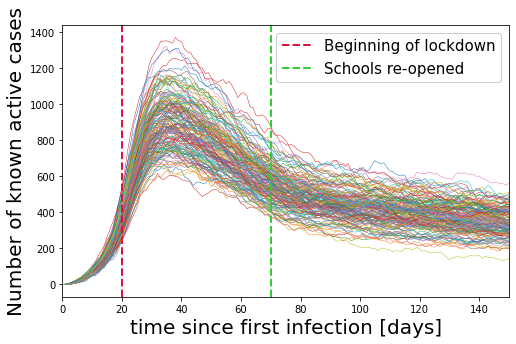

Mean trajectory and standard deviation:


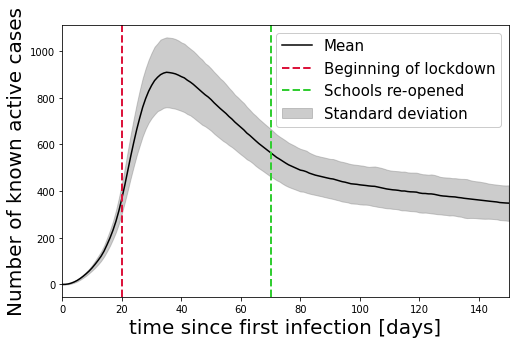

Time from lockdown to local maximum:
Mean time from beginning of lockdown to subsequent peak = 16.2 days


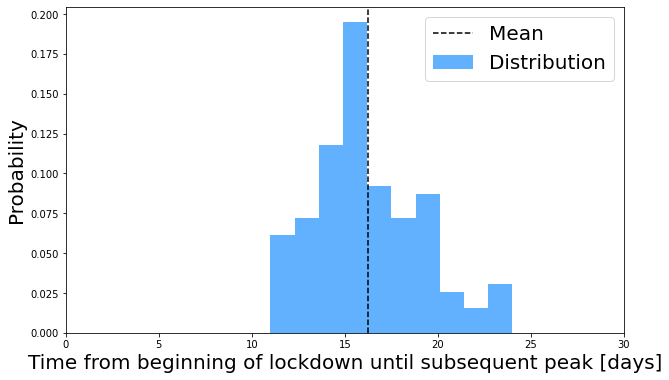

In [15]:
# Plot results

print("Simulated trajectories:")
t = data['t']; 
fig,ax = plt.subplots(1,1,figsize=(8,5))
for i,e in enumerate(data_results2):
    # get total population in classes
    # - symptomatic infective,
    # - hospitalised,
    # - in ICU
    y_plot = np.sum ( e[:,4*M:7*M], axis = -1)
    ax.plot(t,y_plot,lw=0.5,)
ax.axvline(data['events_occured'][0][0],
               color='crimson',lw=lw,
              label='Beginning of lockdown',ls='--')
ax.axvline(data['events_occured'][-1][0],
 color='limegreen',lw=lw,
          label='Schools re-opened',ls='--')
ax.set_xlim(0,Tf)
fs=20
ax.legend(loc='best',fontsize=15,framealpha=1)
ax.set_xlabel('time since first infection [days]',fontsize=fs)
ax.set_ylabel('Number of known active cases',fontsize=fs)
plt.show()
plt.close(fig)


print("Mean trajectory and standard deviation:")
# mean and standard deviation of trajectories at every time
y_mean = np.mean( ( np.sum(data_results2[:,:,4*M:7*M], axis = -1) ), axis=0)
y_std = np.std ( np.sum( data_results2[:,:,4*M:7*M], axis = -1), axis =0)
t = data['t']; 
fig,ax = plt.subplots(1,1,figsize=(8,5))    
ax.fill_between(t,y_mean - y_std,y_mean+y_std,
                label='Standard deviation',
           color='grey',alpha=0.4)
ax.plot(t,y_mean,
        label='Mean',
           color='black',alpha=1)  
ax.axvline(data['events_occured'][0][0],
               color='crimson',lw=lw,
              label='Beginning of lockdown',ls='--')
ax.axvline(data['events_occured'][-1][0],
 color='limegreen',lw=lw,
          label='Schools re-opened',ls='--')
ax.set_xlim(0,Tf)
fs=20
ax.legend(loc='upper right',fontsize=15,framealpha=1)
ax.set_xlabel('time since first infection [days]',fontsize=fs)
ax.set_ylabel('Number of known active cases',fontsize=fs)
plt.show()
plt.close(fig)



print("Time from lockdown to local maximum:")
# calculate time from lockdown to local maximum for each trajectory
mask = (t > lockdown_threshold_0)*(t < lockdown_threshold_2)
t_mask = t[(mask)]
durations_from_lockdown_to_local_maximum2 = np.zeros(N_simulations,
                                                   dtype=float)
for i,e in enumerate(data_results2):
    y_plot = np.sum ( e[:,4*M:7*M], axis = -1)
    index = np.argmax( y_plot[(mask)])
    durations_from_lockdown_to_local_maximum2[i] = t_mask[index] - lockdown_threshold_0
print('Mean time from beginning of lockdown to subsequent peak = {0:3.1f} days'.format(np.mean(durations_from_lockdown_to_local_maximum2)))

hist, bin_edges = np.histogram(durations_from_lockdown_to_local_maximum2,10 ,density=True)
bin_centers = (bin_edges[1:] + bin_edges[:-1])/2.
bin_widths = bin_edges[1]-bin_edges[0]
fig, ax =plt.subplots(1,1,figsize=(10,6))
ax.axvline(np.mean(durations_from_lockdown_to_local_maximum2),ls='--',color='black',
          label='Mean')
ax.bar(bin_centers,hist,bin_widths,color='dodgerblue',
       label='Distribution',alpha=0.7)
ax.set_xlabel('Time from beginning of lockdown until subsequent peak [days]',fontsize=fs)
ax.set_ylabel('Probability',fontsize=fs)
ax.legend(loc='best',fontsize=fs)
ax.set_xlim(0,30)
plt.show()
plt.close(fig)